# Obtaining the first trajectories for a Toy Model


## Getting an initial path

Path sampling methods require that the user supply an input path for each path ensemble. This means that you must somehow generate a first input path. In general, getting the first input paths for TIS boils down to solving two problems:

1. Getting a trajectory that samples the rare event.
2. Filling all the path ensembles with acceptable trajectories.

Since transition paths satisfy all the path ensembles between two states, a common approach is to use the same initial path for all path ensembles (reversing it where necessary). This way, once you've solved problem 1, problem 2 is trivial.

The first rare path can come from any number of sources. The obvious approach might be to find a transition path from a committor analysis, because this would give you a path that satisfies the true dynamics. However, the initial path doesn't *need* to satisfy the true dynamics of the system (later we can equilibrate the path ensemble anyway). This means that other approaches, such as high-temperature trajectories, can be used for the first path. One of the most widely-used methods to get an initial trajectory is to generate a transition trajectory using metadynamics. However, the downside of using paths that don't satisfy the true dynamics is that it might be harder to get them to equilibrate to the correct path ensemble. It seems that this has been more of a problem with paths from high temperature runs than with paths from metadynamics: in the first metadynamics transition, the barrier region is often quite similar to the native dynamics.

In this example, we use a bootstrapping approach, which does create paths satisfying the true dynamics of the system. This bootstrapping is nice because it is quick and convenient, although it works best on smaller systems with less complicated transitions. It works by running normal MD to generate a path that satisfies the innermost interface, and then performing shooting moves in that interface's path ensemble until we have a path that crosses the next interface. Then we switch to the path ensemble for the next interface, and shoot until the path crossing the interface after that. The process continues until we have paths for all interfaces.

In [1]:
# Basic imports
%matplotlib inline
import openpathsampling as paths
import numpy as np

# used for visualization of the 2D toy system
from toy_plot_helpers import ToyPlot

### Basic system setup

First we set up our system: for the toy dynamics, this involves defining a potential energy surface (PES), setting up an integrator, and giving the simulation an initial configuration. In real MD systems, the PES is handled by the combination of a topology file and a force field definition, and the initial configuration would come from a file instead of being described by hand.

In [2]:
# convenience for the toy dynamics
import openpathsampling.toy_dynamics as toys

### Set up the toy system

First we need to describe the system we'll be simulating. With biomolecular systems, this is often done with an initial PDB structure and a choice of force field. For the toy model, we need to give a snapshot as a template, as well as a potential energy surface. The template snapshot also includes a pointer to the topology information (which is relatively simple for the toy systems.)

In [3]:
# Toy_PES supports adding/subtracting various PESs. 
# The OuterWalls PES type gives an x^6+y^6 boundary to the system.
pes = (
    toys.toy_pes.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [0.0, 0.4]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])
)

topology=paths.ToyTopology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

template = paths.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    potential_energy = 0.0, # Important to set energies dimensionless otherwise kcal/mol is default
    kinetic_energy = 0.0,
    topology=topology
)

### Set up the engine

The engine needs the template snapshot we set up above, as well as an integrator and a few other options.

In [4]:
integ = toys.toy_integrators.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'nsteps_per_frame' : 10
}

toy_eng = toys.toy_engine.ToyEngine(
    options=options,
    template=template
)
toy_eng.initialized = True

toy_eng.current_snapshot = template

Finally, we make this engine into the default engine for any `PathMover` that requires an one (e.g., shooting movers, minus movers).

In [5]:
paths.PathMover.engine = toy_eng

Now let's look at the potential energy surface we've created:

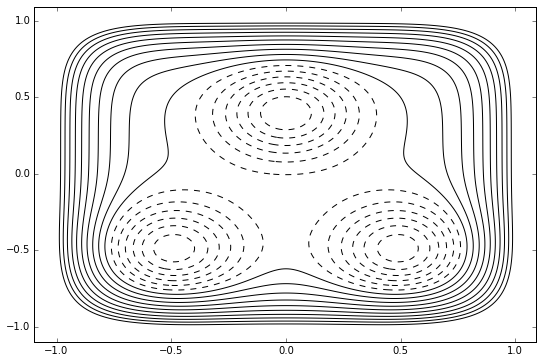

In [6]:
plot = ToyPlot()
plot.contour_range = np.arange(-1.5, 1.0, 0.1)
plot.add_pes(pes)
fig = plot.plot()

### Defining states and interfaces

TIS methods usually require that you define states and interfaces before starting the simulation. State and interfaces are both defined in terms of `Volume` objects. The most common type of `Volume` is one based on some set of collective variables, so the first thing we have to do is to define the collective variable.

For this system, we'll define the collective variables as circles centered on the middle of the state. OPS allows us to define one function for the circle, which is parameterized by different centers. Note that each collective variable is in fact a separate function.

In [7]:
def circle_sq(snapshot, center):
    return (snapshot.xyz[0][0]-center[0])**2 + (snapshot.xyz[0][1]-center[1])**2
    
opA = paths.CV_Function(name="opA", f=circle_sq, center=[-0.5, -0.5], cv_time_reversible=True)
opB = paths.CV_Function(name="opB", f=circle_sq, center=[0.5, -0.5], cv_time_reversible=True)
opC = paths.CV_Function(name="opC", f=circle_sq, center=[0.0, 0.4], cv_time_reversible=True)

Now we define the states and interfaces in terms of these order parameters. The `CVRangeVolumeSet` gives a shortcut to create several volume objects using the same collective variable.

In [8]:
stateA = paths.CVRangeVolume(opA, 0.0, 0.2**2)
stateB = paths.CVRangeVolume(opB, 0.0, 0.2**2)
stateC = paths.CVRangeVolume(opC, 0.0, 0.2**2)

interfacesA = paths.VolumeFactory.CVRangeVolumeSet(opA, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])
interfacesB = paths.VolumeFactory.CVRangeVolumeSet(opB, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])
interfacesC = paths.VolumeFactory.CVRangeVolumeSet(opC, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])

### Build the MSTIS transition network

Once we have the collective variables, states, and interfaces defined, we can create the entire transition network. In this one small piece of code, we create all the path ensembles needed for the simulation, organized into structures to assist with later analysis.

In [9]:
mstis = paths.MSTISNetwork([
    (stateA, interfacesA, "A", opA),
    (stateB, interfacesB, "B", opB),
    (stateC, interfacesC, "C", opC)
])

### Bootstrap to fill all interfaces

Now we actually run the bootstrapping calculation. The `full_bootstrap` function requires an initial snapshot in the state, and then it will generate trajectories satisfying TIS ensemble for the given interfaces. To fill all the ensembles in the MSTIS network, we need to do this once for each initial state.

In [10]:
initA = paths.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[1.0,0.0]]),
)
bootstrapA = paths.FullBootstrapping(
    transition=mstis.from_state[stateA],
    snapshot=initA,
    engine=toy_eng,
    extra_interfaces=[interfacesA[-1]]
)
gsA = bootstrapA.run(300)

DONE! Completed Bootstrapping cycle step 210 in ensemble 4/4 .



In [11]:
initB = paths.Snapshot(
    coordinates=np.array([[0.5, -0.5]]), 
    velocities=np.array([[-1.0,0.0]]),
)

bootstrapB = paths.FullBootstrapping(
    transition=mstis.from_state[stateB], 
    snapshot=initB, 
    engine=toy_eng, 
    extra_interfaces=[interfacesB[-1]]
)
gsB = bootstrapB.run(300)

DONE! Completed Bootstrapping cycle step 212 in ensemble 4/4 .



In [12]:
initC = paths.Snapshot(
    coordinates=np.array([[0.0, 0.4]]), 
    velocities=np.array([[0.0,-0.5]]),
)
bootstrapC = paths.FullBootstrapping(
    transition=mstis.from_state[stateC], 
    snapshot=initC, 
    engine=toy_eng, 
    extra_interfaces=[interfacesC[-1]]
)
gsC = bootstrapC.run(300)

DONE! Completed Bootstrapping cycle step 65 in ensemble 4/4 .



Now that we've done that for all 3 states, let's look at the trajectories we generated.

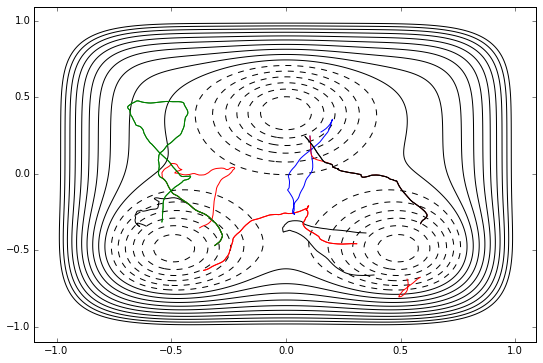

In [13]:
plot.plot([s.trajectory for s in gsA]+[s.trajectory for s in gsB]+[s.trajectory for s in gsC]);

Finally, we join these into one `SampleSet`. The function `relabel_replicas_per_ensemble` ensures that the trajectory associated with each ensemble has a unique replica ID.

In [14]:
total_sample_set = paths.SampleSet.relabel_replicas_per_ensemble([
        gsA, gsB, gsC
    ])

### Storing stuff

Up to this point, we haven't stored anything in files. When we create a file, it also requires the `template` snapshot.

In [15]:
storage = paths.storage.Storage("mstis_bootstrap.nc", "w", template=template)

The storage will recursively store data, so storing `total_sample_set` leads to automatic storage of all the `Sample` objects in that sample set, which in turn leads to storage of all the ensemble, trajectories, and snapshots.

Since the path movers used in bootstrapping and the engine are not required for the sample set, they would not be stored. We explicitly store the engine for later use, but we won't need the path movers, so we don't try to store them.

In [16]:
storage.save(total_sample_set)
storage.save(toy_eng)
storage.cvs.sync()
storage.sync()

Finally, we check to make sure that we actually have stored the objects that we claimed to store. There should be 0 pathmovers, 1 engine, 12 samples (4 samples from each of 3 transitions), and 1 sample set. There will be some larger number of snapshots. There will also be a larger number of ensembles, because each ensemble is defined in terms of subensembles, each of which gets saved.

In [17]:
print "PathMovers:", len(storage.pathmovers)
print "Engines:", len(storage.engines)
print "Samples:", len(storage.samples)
print "SampleSets:", len(storage.samplesets)
print "Snapshots:", len(storage.snapshots)
print "Ensembles:", len(storage.ensembles)

PathMovers: 0
Engines: 1
Samples: 12
SampleSets: 1
Snapshots: 1830
Ensembles: 120


In [18]:
print storage.variables['snapshots_cv_0_values'][:]

[ 0.          0.          0.03676788 ...,  0.79862685  0.80300313
  0.80300313]


In [19]:
storage.cvs.sync()